# Chapter 1. 철판 제조 공정 데이터를 활용한 분류모형 생성 및 성능 비교

## Step 0. 철판 제조 공정 데이터 소개 및 데이터 준비, 학습목표

**Steel Plates Faults 데이터는 1941개의 샘플을 가지며 아래의 종속변수들과 나머지 설명변수들로 구성됩니다.**

- 종속변수 (7개) - 어떠한 불량이 나타났는지를 나타내고, 다음과 같습니다.
 - Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults

- 설명변수 (27개) - 철판의 길이, 반짝이는 정도, 두께, 타입 등 등 다양한 변수들을 가집니다.
 - 첫번째 칼럼 X_Minimum ~ 27번째 칼럼 SigmoidOfAreas

- 데이터출처: https://www.kaggle.com/mahsateimourikia/faults-nna/notebooks



**제조 공정 데이터의 전반적 특성**

- 제조 공정 데이터는 주로 불량률을 예측하여 불량을 일으키는 원인을 제거하거나 재고를 예측하여 수요에 맞는 생산을 진행하는 등의 목적성을 가집니다.
- 다른 데이터에 비하여 데이터를 얻는 과정이 자동화되어 있는 경우가 많아 데이터 퀄리티가 높은 편이며 결측치가 적은 경향성을 가집니다.


### **학습목표**
```
- 각 모델들의 개괄적 이해 및 구축과정 학습.
- 파라미터를 최적화 시키는 GridSearch에 대한 이해 및 코딩작업 체화.
- 각 모델의 중요 파라미터에 대한 개괄적 이해.
- 파라미터의 변화에 따른 예측력 변화 경향성 파악.
- 최적의 모형 및 파라미터를 찾는 과정에 대한 계획 수립 및 수행.
``` 

**아래와 같이 데이터를 준비합니다.**

In [11]:
# 구글 드라이브에 내드라이브에서 P3C1폴더를 생성하여 데이터를 준비하고 이를 마운트합니다.
# 계정 인증을 한 후 코드를 복사하여 붙여넣습니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# 마운트가 제대로 진행되었는지 확인합니다. 아래와 같이 폴더 안에 두 데이터 파일이 포함되어 있는 것으로 출력되어야 합니다.
# file_list: ['Faults27x7_var', 'Faults.NNA']
import os
os.chdir('/content/')
path = "./drive/MyDrive/P3C1"
file_list = os.listdir(path)

print ("file_list: {}".format(file_list))

file_list: ['Faults.NNA', 'Faults27x7_var']


In [13]:
# Working directory를 설정합니다
os.chdir('/content/drive/MyDrive/P3C1/')

In [14]:
import pandas as pd 
import numpy as np

In [15]:
# 데이터를 읽어옵니다.
df = pd.read_csv("Faults.NNA",  delimiter='\t', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [16]:
# 칼럼 레이블을 읽어와서 데이터 프레임의 칼럼명으로 지정합니다.
attributes_name=pd.read_csv("Faults27x7_var",  delimiter=' ', header=None)
df.columns=attributes_name[0]

In [17]:
# 칼럼명이 제대로 지정이 되었는지 여부와 데이터 구조를 파악합니다.
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [18]:
print(df.shape)

(1941, 34)


In [19]:
#Cpu의 개수를 확인합니다. 
n_cpu=os.cpu_count()
print("The number of cpus: ",n_cpu)
n_thread=n_cpu*2
print("Expected number of threads:",n_thread)

The number of cpus:  2
Expected number of threads: 4


## Step 1. 데이터 전처리 및 탐색적 데이터 분석

### 문제 1. 종속변수 범주화 (1) - boolean Seris로 이루어진 list 구성

- 7개의 종속변수들을 각 종속변수가 1인지 아닌지 여부를 알리는 boolean 논리 연산자로 이루어진 seris 형태로 변경합니다. 각 Seris의 길이는 1941입니다.
- 이 7개의 Seris를 list로 이어 붙여 길이 7짜리 list를 만들어 conditions라는 이름으로 저장합니다. 
- 여러 방법이 존재합니다. 방법 1,2는 코드를 제공드리며 풀어주실 문제는 방법3입니다.

In [20]:
## 방법 1. 논리적 연산자 &를 활용하여 생성합니다.
conditions=[(df['Pastry'] == 1) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0), 
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 1)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 1)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 1)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 1)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 1)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 1)]



In [21]:
## 방법 2. pandas.Series.astype을 활용합니다.
conditions=[df['Pastry'].astype(bool),
            df['Z_Scratch'].astype(bool),
            df['K_Scatch'].astype(bool),
            df['Stains'].astype(bool),
            df['Dirtiness'].astype(bool),
            df['Bumps'].astype(bool),
            df['Other_Faults'].astype(bool)]

In [22]:
## (문제) 방법 3. pandas.Series.astype과 map, lambda를 활용합니다
# conditions_bf에 각 변수들의 Seris로 list를 구성합니다.
# conditions_bf을 사용하고 map, lambda를 활용하여 conditions_bf의 각 원소에 astype 함수를 적용합니다.

conditions_bf=[
            df['Pastry'],
            df['Z_Scratch'],
            df['K_Scatch'],
            df['Stains'],
            df['Dirtiness'],
            df['Bumps'],
            df['Other_Faults']]

conditions= list(map(lambda i: i.astype(bool),conditions_bf))

In [23]:
# 잘 진행되었는지 확인합니다.
print(conditions)

[0        True
1        True
2        True
3        True
4        True
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Pastry, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Z_Scratch, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: K_Scatch, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Stains, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Dirtiness, Length: 1941, dtype: bool, 0       False
1 

In [24]:
print(type(conditions))
print(type(conditions[0]))
print(len(conditions))
print(len(conditions[0]))

<class 'list'>
<class 'pandas.core.series.Series'>
7
1941


### 문제 2. 종속변수 범주화 (2) - numpy.select를 활용한 범주화
- 범주화 시 범주명은 각 종속변수의 칼럼명을 그대로 활용합니다.
- (핵심) select 함수는 list 각 원소별로 TRUE인 것들의 값을 지정해줍니다.
- 범주화하여 기존 데이터프레임에 새로운 칼럼 'class'로 저장합니다.

In [25]:
choices = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [26]:
# (문제) numpy.select를 사용하고 위에 정의해드린 choices를 인수로 활용하여 범주화를 진행합니다.
df['class'] = np.select(conditions, choices)

In [27]:
# 아래와 같이 class 칼럼이 생성되고 범주화 된 것을 확인할 수 있습니다.
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,class
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0,Pastry
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0,Pastry
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0,Pastry
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0,Pastry
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0,Pastry


### 문제 3. EDA - 결측치 확인하기

In [28]:
# (문제) pandas.isnull를 활용해 모든 변수에 대하여 결측치가 얼마나 존재하는지를 파악합니다.
df.isnull().sum()

0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
class                    0
dtype: int64

### 문제 4. EDA - 기술통계량 파악하기
- pandas.DataFrame.describe를 활용해 기술통계량을 파악합니다.
 - min과 25% Quantile, max와 75% Quantile을 비교해 이상치 존재가능성에 대해서 파악할 수 있습니다.
 - mean과 50% Quantile을 비교하여 분포의 치우침 정도를 파악할 수 있습니다.
 - 범주형 변수에 대해서는 정보가 제한적입니다
- pandas.Series.value_counts를 활용해 범주화한 종속변수의 기술통계량을 파악합니다.
 - 어떠한 불량타입이 많이 분포하고 적게 분포하는지 파악할 수 있습니다.
 - 적게 분포하는 불량타입의 경우는 예측모형을 구축하는 것이 상대적으로 더 어려울 것입니다.

In [29]:
# (문제) pandas.DataFrame.describe를 활용해 기술통계량을 파악합니다.
df.describe() #min,max를 잘 확인해서 본다

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,1459.160227,0.400309,0.599691,78.737764,0.331715,0.414203,0.570767,0.033361,0.610529,0.813472,0.575734,2.492388,1.335686,1.403271,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,144.577823,0.490087,0.490087,55.086032,0.299712,0.137261,0.271058,0.058961,0.243277,0.234274,0.482352,0.788930,0.481612,0.454345,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.060400,0.315800,0.361300,0.006600,0.411800,0.596800,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,70.000000,0.227300,0.412100,0.555600,0.010100,0.636400,0.947400,1.000000,2.240600,1.176100,1.322200,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,1650.000000,1.000000,1.000000,80.000000,0.573800,0.501600,0.818200,0.023500,0.800000,1.000000,1.000000,2.914900,1.518500,1.732400,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.943900,1.000000,0.875900,1.000000,1.000000,1.000000,5.183700,3.074100,4.258700,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
# (문제) pandas.Series.value_counts를 활용해 범주화한 종속변수의 기술통계량을 파악합니다.
df['class'].value_counts()

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: class, dtype: int64

### 문제 5. 산점도를 통한 변수간의 상관관계 파악

In [31]:
import matplotlib.pyplot as plt

In [32]:
color_code = {'Pastry':'Red', 'Z_Scratch':'Blue', 'K_Scatch':'Green', 'Stains':'Black', 'Dirtiness':'Pink', 'Bumps':'Brown', 'Other_Faults':'Gold'}

In [33]:
# (문제) for문과 위에 정의해드린 dictionary를 활용하여 데이터의 각 행에 해당하는 color값을 지정하는 list를 생성하여 color_list에 저장합니다.
color_list = [color_code.get(i) for i in df.loc[:,'class']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f598483ac10>,
        ...,
        ...,
        ...,
       ...,
        ...,
        ...,
        ...,
      dtype=object)

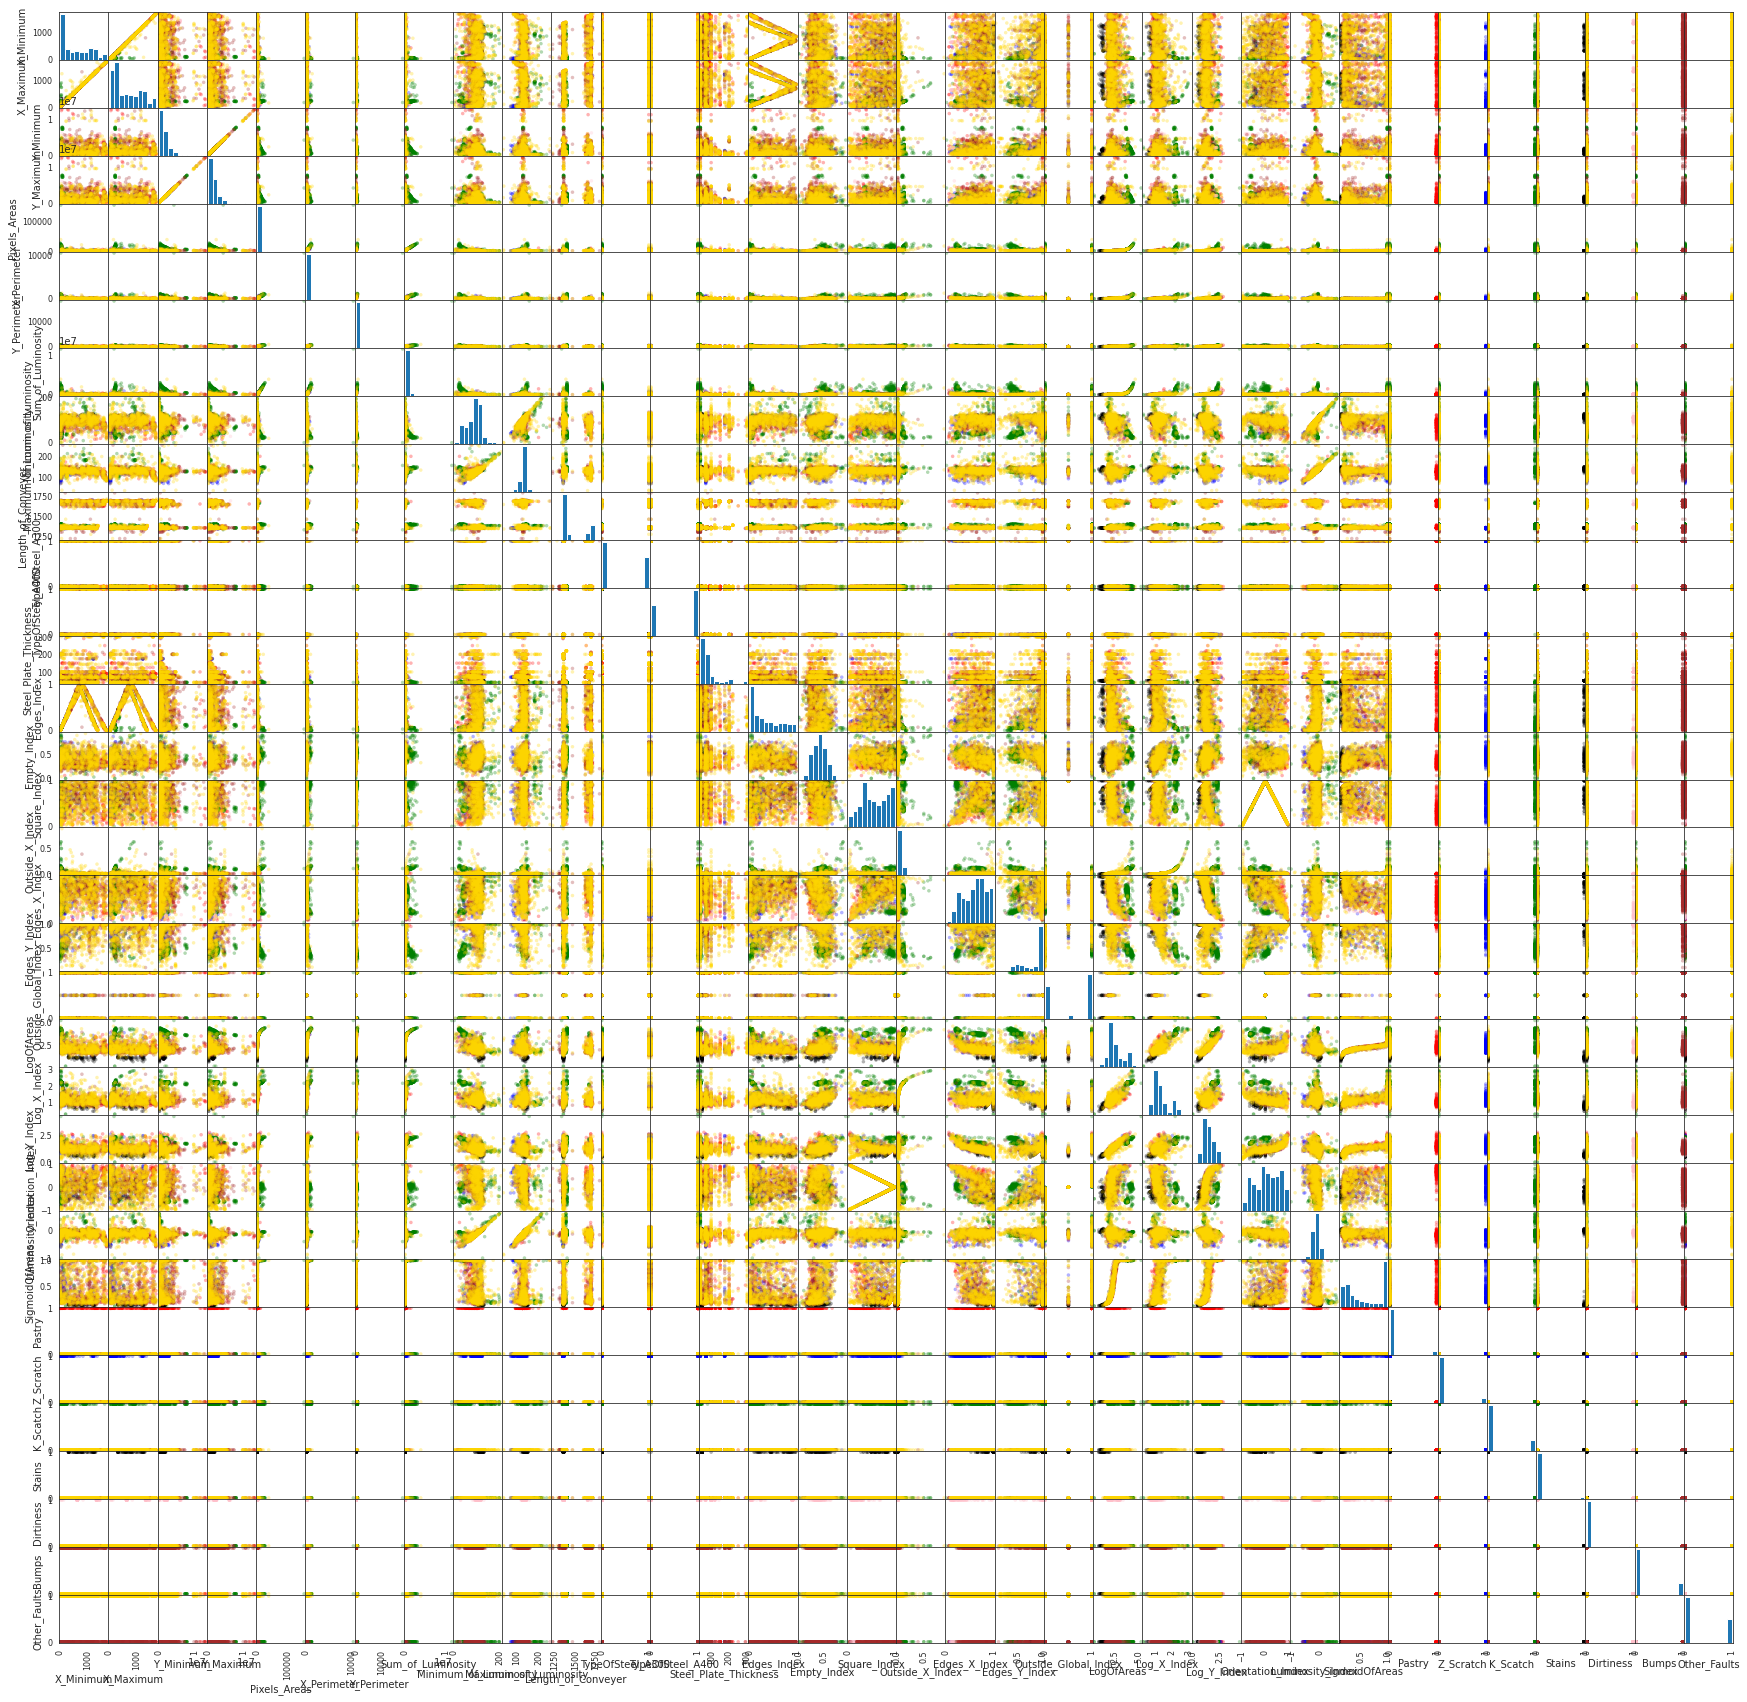

In [34]:
# (문제) pandas.plotting.scatter_matrix, 위에서 만든 color_list를 활용해 scatter plot을 그리고 대각원소에는 히스토그램을 출력해봅니다. figsize= [30,30], alpha=0.3,s = 50 으로 지정합니다.
pd.plotting.scatter_matrix(df.loc[:,df.columns != 'class'], c = color_list,figsize= [30,30], alpha=0.3,s = 50, diagonal = 'hist' ) # 범주형을 제외한 데이터 불러옴

### 문제 6. 범주형 변수의 분포 시각화

In [41]:
import seaborn as sns
sns.set_style("white")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'The number of Defects by Defect type')

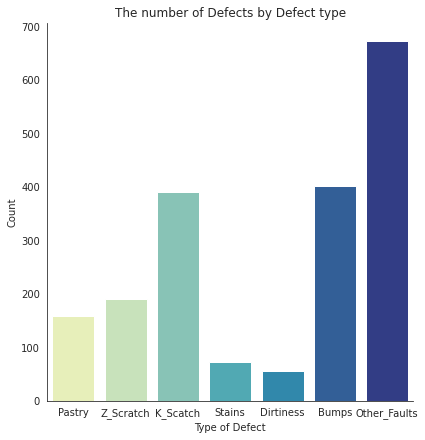

In [42]:
# (문제) seaborn.factorplot을 활용하여 Barplot으로 "class" 변수의 카운트를 표현합니다. 적절한 x축, y축, plot의 title까지 지정해줍니다.
g = sns.factorplot(x = 'class', data = df, kind = 'count', palette = 'YlGnBu', size = 6)
g.ax.xaxis.set_label_text('Type of Defect')
g.ax.yaxis.set_label_text('Count')
g.ax.set_title('The number of Defects by Defect type')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


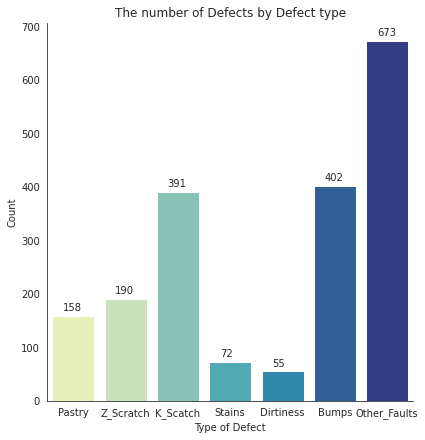

In [43]:
# 이전 cell에서 완성한 코드를 복사 붙여넣기 합니다.
g = sns.factorplot(x = 'class', data = df, kind = 'count', palette = 'YlGnBu', size = 6)
g.ax.xaxis.set_label_text('Type of Defect')
g.ax.yaxis.set_label_text('Count')
g.ax.set_title('The number of Defects by Defect type')
# (문제) Barplot의 bar 상단에 값을 text로 달아줍니다.
for p in g.ax.patches:
  g.ax.annotate((p.get_height()),(p.get_x()+0.2, p.get_height()+10))

### 문제 7. 상관계수를 활용한 변수간의 상관관계 파악

In [44]:
df_corTarget = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]


In [45]:
# (문제) df_corTarget에 대하여, pandas.DataFrame.corr 을 활용해 correlation을 구한 뒤 corr에 저장.
corr = df_corTarget.corr()
corr

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,,,,,,,,,,,,,,,,,,,,,,,,,,,
X_Minimum,1.000000,0.988314,0.041821,0.041807,-0.307322,-0.258937,-0.118757,-0.339045,0.237637,-0.075554,0.316662,0.144319,-0.144319,0.136625,0.278075,-0.198461,0.063658,-0.361160,0.154778,0.367907,0.147282,-0.428553,-0.437944,-0.326851,0.178585,-0.031578,-0.355251
X_Maximum,0.988314,1.000000,0.052147,0.052135,-0.225399,-0.186326,-0.090138,-0.247052,0.168649,-0.062392,0.299390,0.112009,-0.112009,0.106119,0.242846,-0.152680,0.048575,-0.214930,0.149259,0.271915,0.099253,-0.332169,-0.324012,-0.265990,0.115019,-0.038996,-0.286736
Y_Minimum,0.041821,0.052147,1.000000,1.000000,0.017670,0.023843,0.024150,0.007362,-0.065703,-0.067785,-0.049211,0.075164,-0.075164,-0.207640,0.021314,-0.043117,-0.006135,0.054165,0.066085,-0.036543,-0.062911,0.044952,0.070406,-0.008442,-0.086497,-0.090654,0.025257
Y_Maximum,0.041807,0.052135,1.000000,1.000000,0.017840,0.024038,0.024380,0.007499,-0.065733,-0.067776,-0.049219,0.075151,-0.075151,-0.207644,0.021300,-0.043085,-0.006152,0.054185,0.066051,-0.036549,-0.062901,0.044994,0.070432,-0.008382,-0.086480,-0.090666,0.025284
Pixels_Areas,-0.307322,-0.225399,0.017670,0.017840,1.000000,0.966644,0.827199,0.978952,-0.497204,0.110063,-0.155853,-0.235591,0.235591,-0.183735,-0.275289,0.272808,0.017865,0.588606,-0.294673,-0.463571,-0.109655,0.650234,0.603072,0.578342,-0.137604,-0.043449,0.422947
X_Perimeter,-0.258937,-0.186326,0.023843,0.024038,0.966644,1.000000,0.912436,0.912956,-0.400427,0.111363,-0.134240,-0.189250,0.189250,-0.147712,-0.227590,0.306348,0.004507,0.517098,-0.293039,-0.412100,-0.079106,0.563036,0.524716,0.523472,-0.101731,-0.032617,0.380605
Y_Perimeter,-0.118757,-0.090138,0.024150,0.024380,0.827199,0.912436,1.000000,0.704876,-0.213758,0.061809,-0.063825,-0.095154,0.095154,-0.058889,-0.111240,0.188825,-0.047511,0.209160,-0.195162,-0.136723,0.013438,0.294040,0.228485,0.344378,0.031381,-0.047778,0.191772
Sum_of_Luminosity,-0.339045,-0.247052,0.007362,0.007499,0.978952,0.912956,0.704876,1.000000,-0.540566,0.136515,-0.169331,-0.263632,0.263632,-0.204812,-0.301452,0.293691,0.049607,0.658339,-0.327728,-0.529745,-0.121090,0.712128,0.667736,0.618795,-0.158483,-0.014067,0.464248
Minimum_of_Luminosity,0.237637,0.168649,-0.065703,-0.065733,-0.497204,-0.400427,-0.213758,-0.540566,1.000000,0.429605,-0.023579,0.042048,-0.042048,0.103393,0.358915,-0.044111,0.066748,-0.487574,0.252256,0.316610,0.035462,-0.678762,-0.567655,-0.588208,0.057123,0.669534,-0.514797


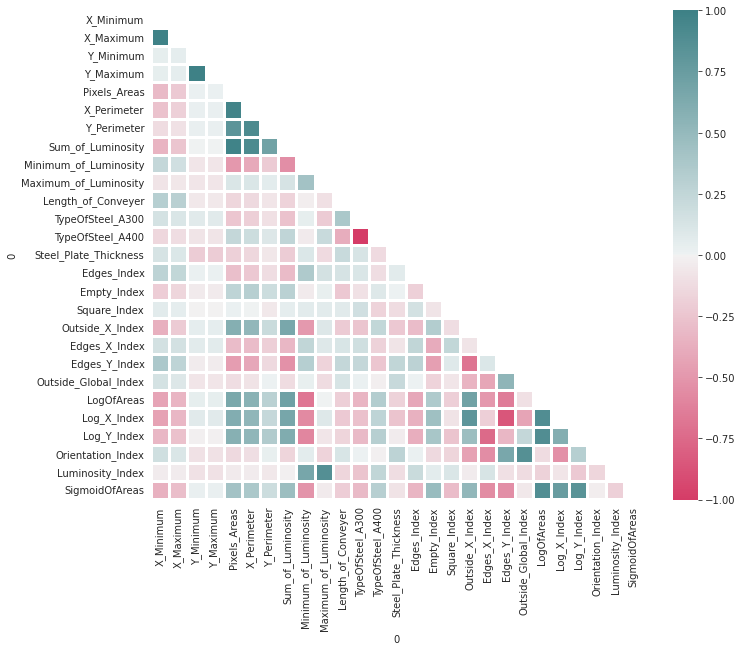

In [46]:
# heatmap을 그리기 위한 파라미터들 설정
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(1,200, as_cmap=True)

# (문제) 저장해둔 corr과 mask, cmap을 활용하여 correlation을 표현하는 heatmap을 그립니다. correlation에 맞게 최대, 최소, 중간값을 지정해줍니다.
# linewidths=2로 설정합니다. 그림 크기는 figsize=(11,9)로 설정합니다.
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, vmin = -1, center = 0, linewidths= 2)

### 문제 8. Training, Test set 분리하기

In [47]:
x = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300',  'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]
y = df['K_Scatch']

In [48]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [88]:
# (문제) sklearn.model_selection.train_test_split을 활용하여, x_train, x_test, y_train, y_test로 데이터를 나눕니다
# 그 비율은 8:2로 합니다. y값에 따라 stratify하여 나눕니다.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 1, stratify = y)

In [89]:
# (문제) pandas.DataFrame.apply를 활용하여  x_train과 x_test를 표준화합니다.
x_train = x_train.apply(zscore)
x_test = x_test.apply(zscore)

In [51]:
x_train.describe() #stand dev 가 1 근처로 된것 -> 표쥰화 됨. mean -> 다들 0에 매우 가까운 값들로 이루어짐

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03
mean,-1.213233e-16,-2.146050e-19,-1.881370e-17,-2.560953e-17,-1.001490e-17,-4.138299e-17,1.087667e-17,-2.353501e-17,2.148911e-16,-6.466584e-16,4.962382e-16,3.161847e-17,4.141876e-17,7.825928e-17,-1.226467e-16,6.717135e-17,-3.912964e-17,1.362384e-16,-2.306288e-16,-2.947242e-17,2.742651e-16,1.005782e-16,-1.280476e-17,1.645305e-17,4.921607e-17,1.347719e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.103367e+00,-1.241076e+00,-9.104613e-01,-9.104788e-01,-3.483794e-01,-3.406371e-01,-1.767603e-01,-3.893515e-01,-2.643140e+00,-5.071400e+00,-1.605681e+00,-8.211077e-01,-6.967596e-01,-1.123421e+00,-3.018160e+00,-2.080335e+00,-5.289097e-01,-2.468152e+00,-3.280170e+00,-1.185811e+00,-2.774003e+00,-2.156377e+00,-3.067242e+00,-2.143465e+00,-5.839974e+00,-1.367353e+00
25%,-9.883000e-01,-8.621817e-01,-6.562362e-01,-6.562372e-01,-3.333730e-01,-3.004833e-01,-1.514077e-01,-3.719521e-01,-6.554519e-01,-3.480654e-01,-7.021989e-01,-8.211077e-01,-6.967596e-01,-9.210483e-01,-7.168723e-01,-7.749740e-01,-4.443167e-01,-7.982123e-01,-9.250766e-01,-1.185811e+00,-7.146692e-01,-6.985005e-01,-6.999318e-01,-8.252854e-01,-4.361607e-01,-9.978418e-01
50%,-2.637179e-01,-2.988794e-01,-2.545875e-01,-2.546108e-01,-3.171771e-01,-2.665069e-01,-1.260551e-01,-3.538504e-01,1.675751e-01,-1.851918e-01,-6.608181e-01,-8.211077e-01,-1.413845e-01,-3.492791e-01,-1.981697e-02,-2.493327e-02,-3.870920e-01,1.006070e-01,5.824951e-01,8.913658e-01,-3.182921e-01,-3.312158e-01,-1.668921e-01,2.490715e-02,-1.325061e-02,-2.443915e-01
75%,9.307593e-01,9.199295e-01,2.919470e-01,2.919292e-01,-2.027537e-01,-8.967550e-02,-1.144025e-02,-2.343737e-01,6.567327e-01,5.205939e-01,1.311669e+00,1.217867e+00,4.374056e-02,8.284349e-01,6.595150e-01,9.383813e-01,-1.623398e-01,7.575785e-01,7.858832e-01,8.913658e-01,5.254920e-01,3.829141e-01,7.329140e-01,8.448359e-01,4.324923e-01,1.226000e+00
max,2.180122e+00,2.203231e+00,6.155444e+00,6.155404e+00,2.758779e+01,3.192762e+01,3.817116e+01,2.140560e+01,3.661558e+00,6.601209e+00,2.304809e+00,1.217867e+00,4.116492e+00,2.211034e+00,3.880404e+00,1.563140e+00,1.397465e+01,1.578793e+00,7.858832e-01,8.913658e-01,3.420237e+00,3.627366e+00,6.274553e+00,1.830314e+00,5.180199e+00,1.226589e+00


## Step 2. 로지스틱 분류 모형


### 문제 9. [로지스틱 회귀분석] 로지스틱 기본 모형 만들기

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [53]:
# (문제) 로지스틱 회귀분석 모형을 만들어 lm에 저장합니다. solver는 'liblinear'로 설정합니다.
lm = LogisticRegression(solver = 'liblinear')

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### 문제 10. [로지스틱 회귀분석] Grid Search 구축 (Lidge, Lasso Penalty / Threshold)

In [90]:
# (문제) 로지스틱에서 고려해야할 Penalty의 형태 (Ridge, Lasso), regularization parameter range를 설정하여 이를 parameters에 dictionary 형태로 저장합니다.
parameters = {'penalty':['l1', 'l2'],'C': [0.01,0.1,0.5,0.9,1,5,10], 'tol' : [1e-4,1e-2,1,1e2]} #C, penalty 로 각각의 회귀계수들이 너무 크지않고 0의 값을 갖도록 함

In [91]:
# (문제) sklearn.model_selection.GridSearchCV를 활용해 cv값 10, n_jobs값은 n_thread로, scoreing은 "accuracy"로 Grid Search를 세팅하고 이를 GSLR에 저장합니다.
GSLR = GridSearchCV(lm, parameters, cv = 10, n_jobs = n_thread, scoring = 'accuracy')

In [92]:
# (문제) Grid Search를 fit함수를 활용하여 수행합니다.
GSLR.fit(x_train,y_train) #cross validation

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 5, 10],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.0001, 0.01, 1, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [61]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', GSLR.best_params_)   
print('best score', GSLR.best_score_)  

final params {'C': 5, 'penalty': 'l1', 'tol': 0.01}
best score 0.9729321753515301


### 문제 11. [로지스틱 회귀분석] 모형 평가 및 최적 로지스틱 모형 구축

In [62]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장합니다.
predicted = GSLR.predict(x_test)

In [66]:
# (문제) sklearn.metrics.confusion_matrix 활용하여 confusion_matrix를 구하고 이를 출력합니다
cMatrix = confusion_matrix(y_test,predicted)
print(cMatrix)
print('Accuracy:', GSLR.score(x_test,y_test))

[[305   6]
 [  5  73]]
Accuracy: 0.9717223650385605


In [67]:
# (문제) sklearn.metrics.classification_report를 활용하여 report를 출력합니다.
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       311
           1       0.92      0.94      0.93        78

    accuracy                           0.97       389
   macro avg       0.95      0.96      0.96       389
weighted avg       0.97      0.97      0.97       389



In [68]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = GSLR.cv_results_['mean_test_score']
stds = GSLR.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GSLR.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print() 
#각가의 값을 변화했을 때 정확도가 어떤지 한번 봐봄

0.945 (+/-0.037) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.0001}
0.945 (+/-0.033) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.01}
0.942 (+/-0.034) for {'C': 0.01, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l1', 'tol': 100.0}
0.949 (+/-0.031) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.0001}
0.949 (+/-0.031) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.01}
0.952 (+/-0.034) for {'C': 0.01, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l2', 'tol': 100.0}
0.964 (+/-0.028) for {'C': 0.1, 'penalty': 'l1', 'tol': 0.0001}
0.963 (+/-0.026) for {'C': 0.1, 'penalty': 'l1', 'tol': 0.01}
0.956 (+/-0.040) for {'C': 0.1, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.1, 'penalty': 'l1', 'tol': 100.0}
0.966 (+/-0.021) for {'C': 0.1, 'penalty': 'l2', 'tol': 0.0001}
0.966 (+/-0.021) for {'C': 0.1, 'penalty': 'l2', 'tol': 0.01}
0.957 (+/-0.030) for {'C': 0.1, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.1, 'penalty': 'l2', 'tol': 100.0}


## Step 3. 의사결정나무 모형

### 문제 12. [의사결정나무] 의사결정나무 기본 모형 만들기

In [93]:
from sklearn.tree import DecisionTreeClassifier

In [94]:
# (문제) 의사결정나무 모형을 만들어 dt에 저장합니다.
dt = DeprecationWarning()

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### 문제 13. [의사결정나무] Grid Search 구축 (Loss function / Prunning)

In [95]:
# (문제) 의사결정나무에서 고려해야할 criterion, min_samples_split, max_depth, min_samples_leaf, max_features 등을 고려하여 Grid search를 수행합니다. -> pruning으로 복잡도를 낮춰 과적합 방지
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.
parameters = {'criterion': ['gini','entropy'], 'min_samples_split':[2,5,10,15], 'max_depth' : [None,2],'min_samples_leaf':[1,3,10,15], 'max_features' : [None,'sqrt','log2']}

In [97]:
GSDT=GridSearchCV(dt,parameters,cv=10,n_jobs=n_thread,scoring="accuracy")
GSDT.fit(x_train,y_train)

TypeError: ignored

In [98]:
print('final params', GSDT.best_params_)   
print('acc', GSDT.best_score_)  

AttributeError: ignored

### 문제 14. [의사결정나무]  모형 평가 및 최적 의사결정나무 구축

In [99]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
predicted=GSDT.predict(x_test)
CMatrix = confusion_matrix(y_test, predicted)
print(cMatrix)
print(round(GSDT.score(x_test,y_test),3))

AttributeError: ignored

In [ ]:
# Train에서의 종속변수의 분포
print(y_train.value_counts())

In [ ]:
# 트리 시각화
import graphviz
dt2=DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features=None,min_samples_leaf=1,min_samples_split=5)
dt2.fit(x_train,y_train)
dot_data=tree.export_graphviz(dt2,feature_names=x_train.columns,filled=True,rounded=True)
graph=graphviz.Source(dot_data)
graph

## Step 4. Random Forest

- Random Forest는 아래의 Bagging과 Drop-out을 활용하여 의사결정나무의 변동성을 완화시키고 예측력을 높인 모델이다.
 - Bootstrapping: 복원추출을 통하여 샘플 구성이 조금씩 다른 여러 데이터셋을 생성해냄.
 - Aggregating: 여러 모형의 결과를 통합하여 모형의 변동성을 낮춤.
 - Drop-out: Tree를 구성할 때 변수를 일부 탈락시킴. Tree간의 correlation을 감소시켜 이 또한 모형의 변동성을 낮춤.

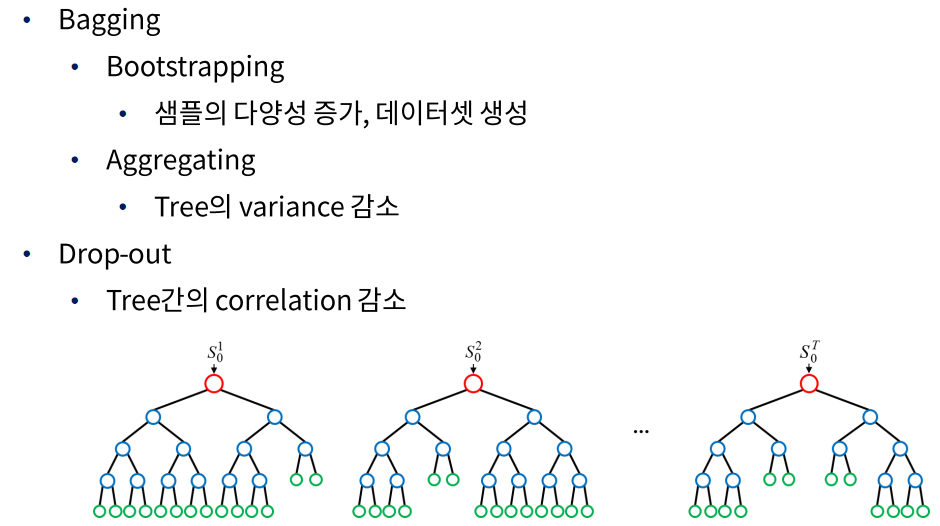

### 문제 15. [Random Forest]  Random Forest 기본 모형 만들기

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
# (문제) Random Forest 모형을 만들어 rf에 저장합니다.
rf=RandomForestClassifier()

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 문제 16. [Random Forest] Grid Search 구축 (Loss function / Prunning / 변수 선택 / Tree 개수)

In [103]:
# (문제) Random Forest에서 고려해야할 n_estimators, min_samples_split, max_depth, min_samples_leaf, max_features 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.
parameters={'n_estimators':[50,100],'criterion':['entropy'],'min_samples_split':[2,5],'max_depth':[None,2],'min_samples_leaf':[1,3,10],'max_features':['sqrt']} #트리가 많으면 좋지만 너무 오래걸림
GSRF=GridSearchCV(rf,parameters,cv=10,n_jobs=n_thread,scoring="accuracy")
GSRF.fit(x_train,y_train)
print('final params',GSRF.best_params_)
print('best score',GSRF.best_score_)

final params {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
best score 0.9838957816377173


### 문제 17. [Random Forest] 모형 평가 및 최적  Random Forest 구축

In [104]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
predicted=GSRF.predict(x_test)
cMatrix=confusion_matrix(y_test,predicted)
print(cMatrix)
print(metrics.classification_report(y_test,predicted))

[[311   0]
 [  6  72]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       311
           1       1.00      0.92      0.96        78

    accuracy                           0.98       389
   macro avg       0.99      0.96      0.98       389
weighted avg       0.98      0.98      0.98       389



## Step 5. Support Vector Machine

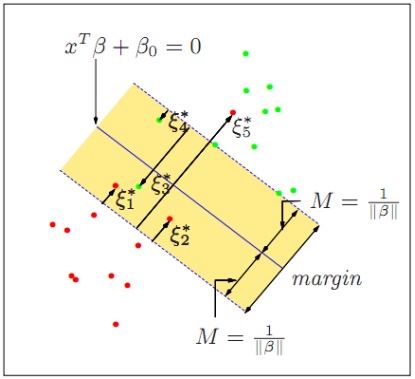

- 노란색 margin을 최대화하는 boundary를 찾는 것이 목표.
- Error를 허용하는 정도를 C로 표현한다.
 - C가 크면 Error를 많이 허용하고, C가 작을 수록 Error를 적게 허용한다.

Image reference: Fastcampus 머신러닝과 데이터 분석 A-Z 




### 문제 18. [SVM] Support Vector Machine 기본 모형 만들기

In [105]:
from sklearn import svm

In [106]:
# (문제) Support Vector Machine을 만들어 svc에 저장합니다.
svc=svm.SVC()

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### 문제 19. [SVM] Grid Search 구축 (Regularization / Kernel / Gamma)

In [107]:
# (문제) Support Vector Machine에서 고려해야할 C, kernel, gamma 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.
parameters={'C':[0.01,0.1,0.5,0.9,1,5,10],'kernel':['linear','rbf','poly'],'gamma':[0.1,1,10]} #선형,비선형으로 다 margin을 만들어봄
GS_SVM=GridSearchCV(svc,parameters,cv=10,n_jobs=n_thread,scoring="accuracy")
GS_SVM.fit(x_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 5, 10],
                         'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

### 문제 20. [SVM] 모형 평가 및 최적 Support Vector Machine 구축

In [108]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
print('final params',GS_SVM.best_params_)
print('best score',GS_SVM.best_score_)

final params {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
best score 0.9826137303556658


## Step 6. 신경망 모형

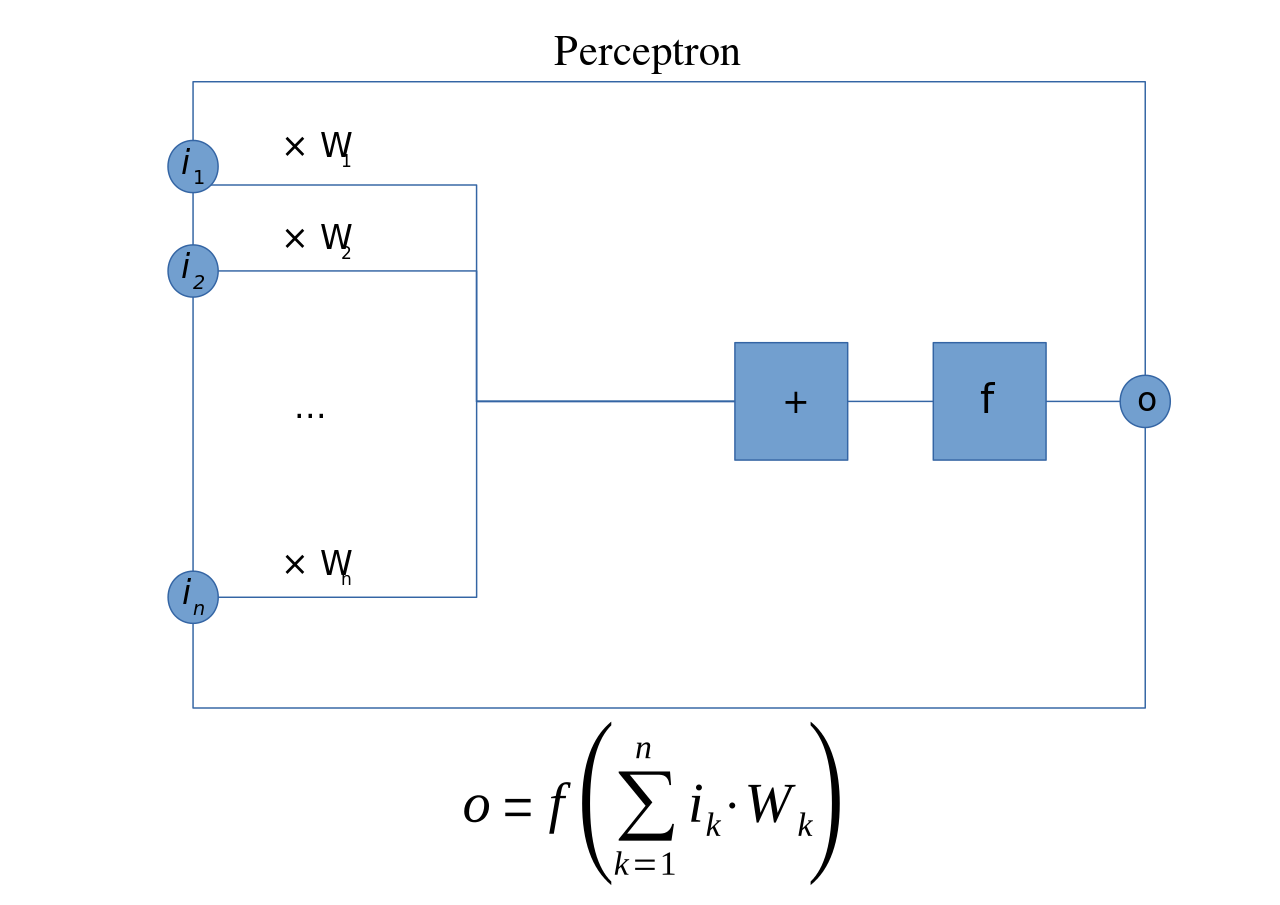

- 신경망 모형은 위와 같이 입력 데이터를 종합하여 결과값을 내는 구조를 가진 Perceptron을 중첩시키고 혼합시킨 구조이다. 아래와 같이 두 부분으로 나누어볼 수 있다.
 - 입력값들의 선형합 구조인 transfer function
 - activation function f()
- 이 때 입력값은 다른 perceptron의 출력값이 될 수 있으며 이것이 중첩되면 아래와 같이 나타날 수 있으며 이를 신경망 모형이라 한다.
 - Input Layer: 입력 데이터가 위치하는 layer.
 - Hidden Layer: 입력 데이터 혹은 또 다른 hidden layer의 출력값을 입력값으로 하는 perceptron이 위치하는 layer.
 - Output Layer:마지막 hidden layer의 출력값을 입력값고 출력함수의 결과를 얻은 노드로 구성된 layer.

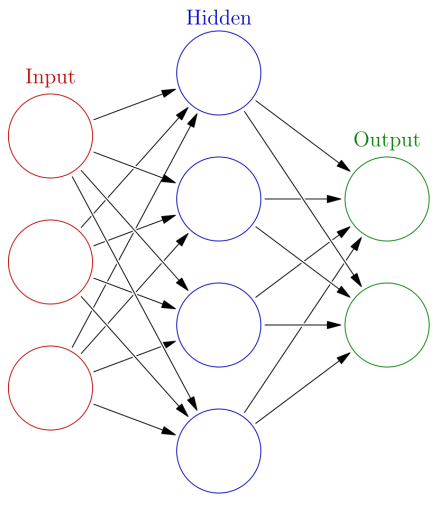

### 문제 21. [ANN] 신경망 모형  기본 모형 만들기

In [109]:
from sklearn.neural_network import MLPClassifier

In [110]:
# (문제) 신경망 모형을 만들어 ann_model에 저장합니다.
nn_model=MLPClassifier(random_state=1)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

### 문제 22. [ANN] Grid Search 구축 (Hidden Layer 수 / Hidden node 수 / Regularization)

- 히든레이어는 많은 경우 1개로도 충분함.
- 히든 노드의 수는 아래와 같은 가이드라인 또한 존재하나, grid search를 통해서 찾는 것을 추천함.

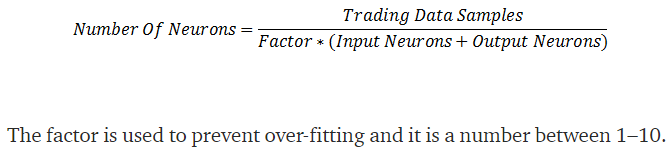

In [111]:
x_train.shape

(1552, 26)

In [112]:
1552/(10*(26+1)) # 이계산을 통해 factor의 범위를 찾고 노드수를 결정한다

5.7481481481481485

In [113]:
1552/(1*(26+1))

57.48148148148148

In [119]:
# (문제) 신경망 모형에서 고려해야할 alpha, hidden_layer_sizes, activation등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.
parameters={'alpha':[1e-3,1e-1,1e1],'hidden_layer_sizes':[(5),(10),(60)],'activation':['tanh','relu'],'solver':['adam','lbfgs']}
GS_NN=GridSearchCV(nn_model,parameters,cv=10,n_jobs=n_thread,scoring="accuracy")
GS_NN.fit(x_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'act

### 문제 23. [ANN] 모형 평가 및 최적 신경망 모형 구축

In [120]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
print('final params', GS_NN.best_params_)
print('best score', GS_NN.best_score_)

final params {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 30, 'solver': 'lbfgs'}
best score 0.9793796526054592


In [121]:
means = GS_NN.cv_results_['mean_test_score']
stds = GS_NN.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GS_NN.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.970 (+/-0.021) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 5, 'solver': 'adam'}
0.971 (+/-0.030) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 5, 'solver': 'lbfgs'}
0.974 (+/-0.022) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 30, 'solver': 'adam'}
0.974 (+/-0.020) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 30, 'solver': 'lbfgs'}
0.977 (+/-0.025) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'adam'}
0.976 (+/-0.021) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'lbfgs'}
0.969 (+/-0.021) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 5, 'solver': 'adam'}
0.974 (+/-0.029) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 5, 'solver': 'lbfgs'}
0.974 (+/-0.021) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 30, 'solver': 'adam'}
0.979 (+/-0.026) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_laye

https://playground.tensorflow.org

## Step 7. Boosting

- 오분류된 데이터에 가중치를 더 주어 샘플링하여 이를 잘 분류하기 위한 합성 분류기를 구성하는 방법

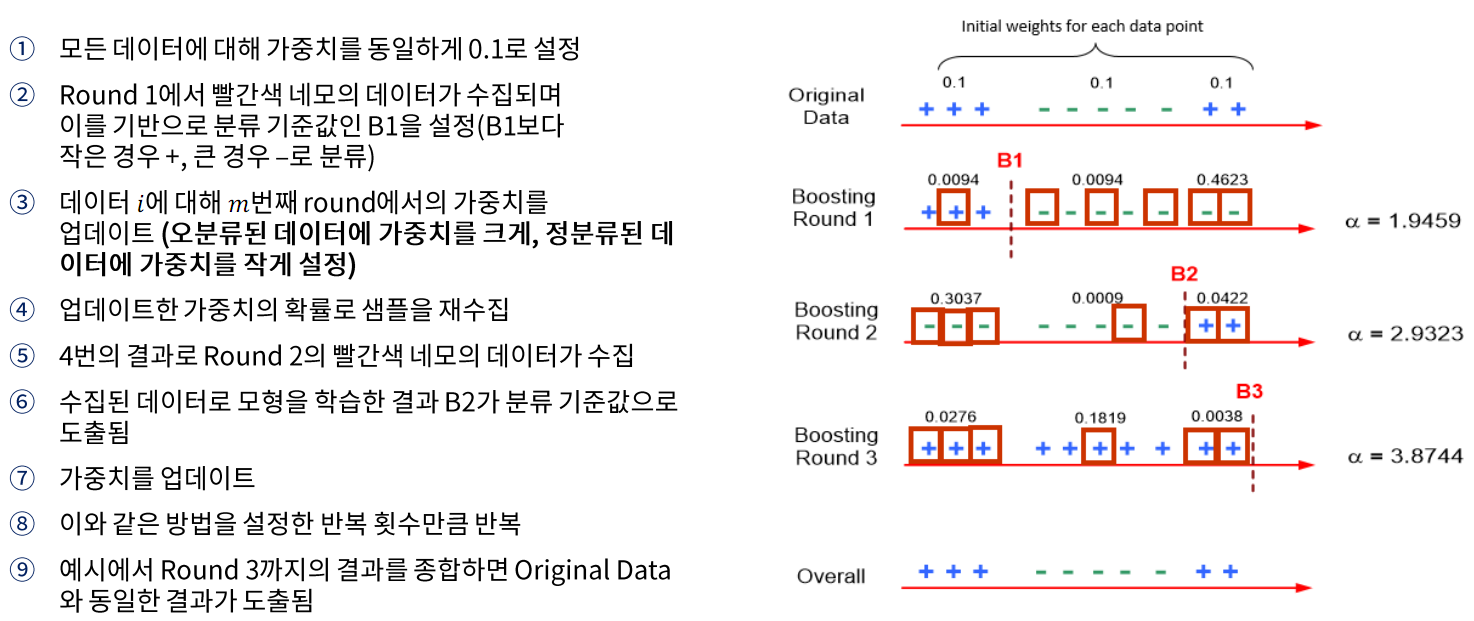

Image reference: Fastcampus 머신러닝과 데이터 분석 A-Z 이경택 강사





### 문제 24. [Boosting] xgboost 기본 모형 만들기

- xgboost는 기본적인 gradient boosting에 과정합을 방지하기 위한 regularization term이 추가된 형태.

In [122]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [123]:
# (문제) xgboost 모형을 만들어 xgb_model에 저장합니다. objective='binary:logistic'로 설정합니다.
xgb_model=xgb.XGBClassifier(objective='binary:logistic')

https://xgboost.readthedocs.io/en/latest/parameter.html

### 문제 25. [Boosting] xgboost Grid Search 구축 (Max depth / Tree 개수/ Gamma)

In [124]:
# (문제) xgboost에서 고려해야할 max_depth, min_child_weight, gamma, colsample_bytree, n_estimators 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.
parameters={
    'max_depth':[5,8],
    'min_child_weight':[1,5],
    'gamma':[0,1],
    'colsample_bytree':[0.8,1],
    'colsample_bylevel':[0.9,1],
    'n_estimators':[50,100]
}
GS_xgb=GridSearchCV(xgb_model,param_grid=parameters,cv=10,n_jobs=n_thread,scoring="accuracy")
GS_xgb.fit(x_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bylevel': [0.9, 1],
                         'colsample_bytree': [0.8, 1], 'gamma': [0, 1],
                         'max_depth': [5, 8], 'min_

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

### 문제 26. [Boosting] 모형 평가 및 최적 xgboost 모형 구축

In [125]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
print('final params',GS_xgb.best_params_)
print('best score',GS_xgb.best_score_)

final params {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}
best score 0.9851819685690654


In [ ]:
parameters2={
    'max_depth':[3,5,7],
    'min_child_weight':[1],
    'gamma':[0],
    'colsample_bytree':[1],
    'colsample_bylevel':[1],
    'n_estimators':[100,150]
}

GS_xgb2=GridSearchCV(xgb_model,param_grid=parameters2,cv=10,n_jobs=n_thread,scoring="accuracy")
GS_xgb2.fit(x_train,y_train)

In [ ]:
predicted=GS_xgb2.predict(x_test)
cMatrix=confusion_matrix(y_test,predicted)
print(cMatrix)
print(metrics.classification_report(y_test,predicted))

### 문제 27. [Boosting] lightGBM 기본 모형 만들기

- xgboost에 비교할 때 성능은 비슷함.
- leaf-wise loss를 사용함. 
  - 시간과 메모리를 절약하여, fitting 속도 빠름.
  - 데이터의 수가 충분하지 않다면 과적합의 위험이 좀 더 높음.

In [131]:
import lightgbm as lgb

In [132]:
# (문제) lightgbm 모형을 만들어 lgbm_model에 저장합니다. objective='binary' 로 설정합니다.


https://lightgbm.readthedocs.io/en/latest/Parameters.html

###문제 28. [Boosting] lightGBM  Grid Search 구축 (Max depth / Tree 개수)

In [133]:
# (문제) lightGBM에서 주로 고려해야할 num_leaves, min_data_in_leaf, colsample_bytree, n_estimators 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.
lgbm_model=lgb.LGBMClassifier(objecve='binary')

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

### 문제 29. [Boosting] 모형 평가 및 최적 lightGBM 모형 구축

In [134]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
parameters={
    'num_leaves':[32,64,128],
    'min_data_in_leaf':[1,5,10],
    'colsample_bytree':[0.8,1],
    'n_estimators':[100,150]
}

In [135]:
GS_lgbm=GridSearchCV(lgbm_model,parameters,cv=10,n_jobs=n_thread,scoring="accuracy")
GS_lgbm.fit(x_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      objecve='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytr

In [136]:
print('final params',GS_lgbm.best_params_)
print('best score',GS_lgbm.best_score_)

final params {'colsample_bytree': 0.8, 'min_data_in_leaf': 5, 'n_estimators': 150, 'num_leaves': 64}
best score 0.9864681555004136


In [137]:
predicted=GS_lgbm.predict(x_test)
cMatrix=confusion_matrix(y_test,predicted)
print(cMatrix)
print(metrics.classification_report(y_test,predicted))

[[311   0]
 [  4  74]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       311
           1       1.00      0.95      0.97        78

    accuracy                           0.99       389
   macro avg       0.99      0.97      0.98       389
weighted avg       0.99      0.99      0.99       389



## Chapter 1. 요약 및 마무리
- 학습한 것:
 - 기초 학습 내용은 각 모델들의 구축과정, 이 파라미터를 최적화 시키는 GridSearch에 대한 활용입니다. 이는 본 강의를 통하여 100% 학습하셨을 것입니다.
 - 심화 학습 내용은 위의 내용들을 데이터의 특성과 모델 방법론에 대한 개괄적 이해를 바탕으로 한 적정한 모델의 선택과 파라미터를 최적화 시키는 관점에서 바라보고 이해하는 것입니다. 

- 본 강의의 활용:
 - 제가 각 방법론의 최적 모형을 구축하면서 코멘트 드렸던 모형 별 중요 파라미터와 이 파라미터들이 가지는 의미, 파라미터들의 변화에 따른 예측력의 변화 경향성을 바탕으로 여러 데이터에서 데이터의 특성에 따른 모델의 성능과 최적 파라미터가 가지는 경향성을 경험적으로 익히시는 것이 필요합니다.
